In [ ]:
#BINARY CLASSIFICATION - 8 PC

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_curve, average_precision_score, roc_curve, auc
from sklearn.utils import resample
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv("8 PC.csv")

# Ensure class distributions
print("Original Class Distribution:")
print(df['flare_class_encoded'].value_counts())

# Update labels for binary classification
def encode_binary_class(row):
    if row['flare_class_encoded'] < 300:
        return 0  # B/C class
    else:
        return 1  # M/X class

df['binary_class'] = df.apply(encode_binary_class, axis=1)
print("Binary Class Distribution:")
print(df['binary_class'].value_counts())

def create_binary_splits(df, n_repeats=100):
    all_splits = []

    for repeat in range(n_repeats):
        try:
            # Randomly select unique samples for each binary class
            bc_class_samples = resample(df[df['binary_class'] == 0], replace=False, n_samples=165, random_state=repeat)
            mx_class_samples = resample(df[df['binary_class'] == 1], replace=False, n_samples=165, random_state=repeat)

            # Combine selected samples to form a complete dataset
            complete_data = pd.concat([bc_class_samples, mx_class_samples])
            X = complete_data.drop(columns=['flare_class_encoded', 'binary_class'])
            y = complete_data['binary_class']  # Target value

            all_splits.append((X, y))
        except ValueError as e:
            print(f"Repeat {repeat}: Error - {e}")
            continue

    return all_splits

def evaluate_model_with_knn(X, y, n_splits=10):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    param_grid = {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }

    model_knn = KNeighborsClassifier()
    grid_search = GridSearchCV(estimator=model_knn, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

    accuracy_scores = []
    roc_auc_scores = []
    pr_auc_scores = []
    best_params_list = []
    fpr_list = []
    tpr_list = []
    precision_list = []
    recall_list = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        grid_search.fit(X_train, y_train)
        best_model_knn = grid_search.best_estimator_
        best_params_list.append(grid_search.best_params_)

        y_pred = best_model_knn.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)

        test_pred_prob = best_model_knn.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, test_pred_prob)
        roc_auc_scores.append(roc_auc)

        precision, recall, _ = precision_recall_curve(y_test, test_pred_prob)
        pr_auc = average_precision_score(y_test, test_pred_prob)
        pr_auc_scores.append(pr_auc)

        fpr, tpr, _ = roc_curve(y_test, test_pred_prob)
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        precision_list.append((precision, len(precision)))
        recall_list.append((recall, len(recall)))

    return np.mean(accuracy_scores), np.mean(roc_auc_scores), np.mean(pr_auc_scores), best_params_list, accuracy_scores, roc_auc_scores, pr_auc_scores, fpr_list, tpr_list, precision_list, recall_list

# Create binary splits
binary_splits = create_binary_splits(df)
if len(binary_splits) == 0:
    print("No valid splits created.")
else:
    mean_acc_list = []
    mean_roc_auc_list = []
    mean_pr_auc_list = []
    best_params_list = []
    all_accuracy_scores = []
    all_roc_auc_scores = []
    all_pr_auc_scores = []
    all_fpr = []
    all_tpr = []
    all_precision = []
    all_recall = []

    for X, y in binary_splits:
        (mean_acc, mean_roc_auc, mean_pr_auc, best_params, accuracy_scores, roc_auc_scores, pr_auc_scores, fpr_list, tpr_list, precision_list, recall_list) = evaluate_model_with_knn(X, y)
        mean_acc_list.append(mean_acc)
        mean_roc_auc_list.append(mean_roc_auc)
        mean_pr_auc_list.append(mean_pr_auc)
        best_params_list.extend(best_params)
        all_accuracy_scores.extend(accuracy_scores)
        all_roc_auc_scores.extend(roc_auc_scores)
        all_pr_auc_scores.extend(pr_auc_scores)
        all_fpr.extend(fpr_list)
        all_tpr.extend(tpr_list)
        all_precision.extend(precision_list)
        all_recall.extend(recall_list)

    overall_mean_accuracy = np.mean(mean_acc_list)
    overall_mean_roc_auc = np.mean(mean_roc_auc_list)
    overall_mean_pr_auc_8PC = np.mean(mean_pr_auc_list)

    print(f"Overall Mean Accuracy: {overall_mean_accuracy}")
    print(f"Overall Mean ROC AUC: {overall_mean_roc_auc}")
    print(f"Overall Mean PR AUC: {overall_mean_pr_auc_8PC}")

    # Plot Mean ROC AUC Curve
    mean_fpr_8PC = np.linspace(0, 1, 100)
    mean_tpr_8PC = np.mean([np.interp(mean_fpr_8PC, fpr, tpr) for fpr, tpr in zip(all_fpr, all_tpr)], axis=0)
    mean_tpr_8PC[-1] = 1.0
    mean_roc_auc_8PC = auc(mean_fpr_8PC, mean_tpr_8PC)

    plt.figure(figsize=(10, 6))
    #plt.plot(mean_fpr, mean_tpr, color='green', label=f'Mean ROC (8 PC) (AUC = {mean_roc_auc8:.2f})', lw=2, alpha=.8)
    plt.plot(mean_fpr_8PC, mean_tpr_8PC, color='orange', label=f'Mean ROC (8 PC) (AUC = {mean_roc_auc_8PC:.2f})', lw=2, alpha=.8)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate',fontsize=16)
    plt.ylabel('True Positive Rate',fontsize=16)
    plt.title('Mean ROC AUC Curve',fontsize=18)
    plt.legend(loc="lower right")
    plt.show()

    # Interpolate precision-recall to a common set of recall points for mean calculation
    mean_precision_8PC = np.zeros_like(mean_fpr_8PC)
    for precision, length in all_precision:
        mean_precision_8PC += np.interp(mean_fpr_8PC, np.linspace(0, 1, length), precision)
    mean_precision_8PC /= len(all_precision)

    mean_recall_8PC = np.mean([np.interp(mean_fpr_8PC, np.linspace(0, 1, length), recall) for recall, length in all_recall], axis=0)

    # Plot Mean Precision-Recall Curve
    plt.figure(figsize=(10, 6))
    #plt.plot(mean_recall8, mean_precision8, color='green', label=f'Mean PR (8 PC) (AUC = {overall_mean_pr_auc8:.2f})', lw=2, alpha=.8)
    plt.plot(mean_recall_8PC, mean_precision_8PC, color='orange', label=f'Mean PR (8 PC) (AUC = {overall_mean_pr_auc_8PC:.2f})', lw=2, alpha=.8)
    plt.xlabel('Recall',fontsize=16)
    plt.ylabel('Precision',fontsize=16)
    plt.title('Mean Precision-Recall Curve',fontsize=18)
    plt.legend(loc="lower left")
    plt.show()

# Print final class distributions for debugging
if len(binary_splits) > 0:
    X, y = binary_splits[0]
    print(f"Final Training Set Class Distribution:\n{y.value_counts()}")


In [ ]:
#BINARY CLASSIFICATION - 100 PC

# Load your dataset
df = pd.read_csv("100 PC.csv")

# Ensure class distributions
print("Original Class Distribution:")
print(df['flare_class_encoded'].value_counts())

# Update labels for binary classification
def encode_binary_class(row):
    if row['flare_class_encoded'] < 300:
        return 0  # B/C class
    else:
        return 1  # M/X class

df['binary_class'] = df.apply(encode_binary_class, axis=1)
print("Binary Class Distribution:")
print(df['binary_class'].value_counts())

def create_binary_splits(df, n_repeats=10):
    all_splits = []

    for repeat in range(n_repeats):
        try:
            # Randomly select unique samples for each binary class
            bc_class_samples = resample(df[df['binary_class'] == 0], replace=False, n_samples=165, random_state=repeat)
            mx_class_samples = resample(df[df['binary_class'] == 1], replace=False, n_samples=165, random_state=repeat)

            # Combine selected samples to form a complete dataset
            complete_data = pd.concat([bc_class_samples, mx_class_samples])
            X = complete_data.drop(columns=['flare_class_encoded', 'binary_class'])
            y = complete_data['binary_class']  # Target value

            all_splits.append((X, y))
        except ValueError as e:
            print(f"Repeat {repeat}: Error - {e}")
            continue

    return all_splits

def evaluate_model_with_knn(X, y, n_splits=10):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    param_grid = {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }

    model_knn = KNeighborsClassifier()
    grid_search = GridSearchCV(estimator=model_knn, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

    accuracy_scores = []
    roc_auc_scores = []
    pr_auc_scores = []
    best_params_list = []
    fpr_list = []
    tpr_list = []
    precision_list = []
    recall_list = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        grid_search.fit(X_train, y_train)
        best_model_knn = grid_search.best_estimator_
        best_params_list.append(grid_search.best_params_)

        y_pred = best_model_knn.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)

        test_pred_prob = best_model_knn.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, test_pred_prob)
        roc_auc_scores.append(roc_auc)

        precision, recall, _ = precision_recall_curve(y_test, test_pred_prob)
        pr_auc = average_precision_score(y_test, test_pred_prob)
        pr_auc_scores.append(pr_auc)

        fpr, tpr, _ = roc_curve(y_test, test_pred_prob)
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        precision_list.append((precision, len(precision)))
        recall_list.append((recall, len(recall)))

    return np.mean(accuracy_scores), np.mean(roc_auc_scores), np.mean(pr_auc_scores), best_params_list, accuracy_scores, roc_auc_scores, pr_auc_scores, fpr_list, tpr_list, precision_list, recall_list

# Create binary splits
binary_splits = create_binary_splits(df)
if len(binary_splits) == 0:
    print("No valid splits created.")
else:
    mean_acc_list = []
    mean_roc_auc_list = []
    mean_pr_auc_list = []
    best_params_list = []
    all_accuracy_scores = []
    all_roc_auc_scores = []
    all_pr_auc_scores = []
    all_fpr = []
    all_tpr = []
    all_precision = []
    all_recall = []

    for X, y in binary_splits:
        (mean_acc, mean_roc_auc, mean_pr_auc, best_params, accuracy_scores, roc_auc_scores, pr_auc_scores, fpr_list, tpr_list, precision_list, recall_list) = evaluate_model_with_knn(X, y)
        mean_acc_list.append(mean_acc)
        mean_roc_auc_list.append(mean_roc_auc)
        mean_pr_auc_list.append(mean_pr_auc)
        best_params_list.extend(best_params)
        all_accuracy_scores.extend(accuracy_scores)
        all_roc_auc_scores.extend(roc_auc_scores)
        all_pr_auc_scores.extend(pr_auc_scores)
        all_fpr.extend(fpr_list)
        all_tpr.extend(tpr_list)
        all_precision.extend(precision_list)
        all_recall.extend(recall_list)

    overall_mean_accuracy = np.mean(mean_acc_list)
    overall_mean_roc_auc = np.mean(mean_roc_auc_list)
    overall_mean_pr_auc_100PC = np.mean(mean_pr_auc_list)

    print(f"Overall Mean Accuracy: {overall_mean_accuracy}")
    print(f"Overall Mean ROC AUC: {overall_mean_roc_auc}")
    print(f"Overall Mean PR AUC: {overall_mean_pr_auc_100PC}")

    # Plot Mean ROC AUC Curve
    mean_fpr_100PC = np.linspace(0, 1, 100)
    mean_tpr_100PC = np.mean([np.interp(mean_fpr_100PC, fpr, tpr) for fpr, tpr in zip(all_fpr, all_tpr)], axis=0)
    mean_tpr_100PC[-1] = 1.0
    mean_roc_auc_100PC = auc(mean_fpr_100PC, mean_tpr_100PC)

    plt.figure(figsize=(10, 6))
    plt.plot(mean_fpr_100PC, mean_tpr_100PC, color='orange', label=f'Mean ROC (100 PC) (AUC = {mean_roc_auc_100PC:.2f})', lw=2, alpha=.8)
    plt.plot(mean_fpr_8PC, mean_tpr_8PC, color='green', label=f'Mean ROC (8 PC) (AUC = {mean_roc_auc_8PC:.2f})', lw=2, alpha=.8)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate',fontsize=16)
    plt.ylabel('True Positive Rate',fontsize=16)
    plt.title('Mean ROC AUC Curve',fontsize=18)
    plt.legend(loc="lower right")
    plt.show()

    # Interpolate precision-recall to a common set of recall points for mean calculation
    mean_precision_100PC = np.zeros_like(mean_fpr_100PC)
    for precision, length in all_precision:
        mean_precision_100PC += np.interp(mean_fpr_100PC, np.linspace(0, 1, length), precision)
    mean_precision_100PC /= len(all_precision)

    mean_recall_100PC = np.mean([np.interp(mean_fpr_100PC, np.linspace(0, 1, length), recall) for recall, length in all_recall], axis=0)

    # Plot Mean Precision-Recall Curve
    plt.figure(figsize=(10, 6))
    plt.plot(mean_recall_100PC, mean_precision_100PC, color='green', label=f'Mean PR (100 PC) (AUC = {overall_mean_pr_auc_100PC:.2f})', lw=2, alpha=.8)
    plt.plot(mean_recall_8PC, mean_precision_8PC, color='orange', label=f'Mean PR (8 PC) (AUC = {overall_mean_pr_auc_8PC:.2f})', lw=2, alpha=.8)
    plt.xlabel('Recall',fontsize=16)
    plt.ylabel('Precision',fontsize=16)
    plt.title('Mean Precision-Recall Curve',fontsize=18)
    plt.legend(loc="lower left")
    plt.show()

# Print final class distributions for debugging
if len(binary_splits) > 0:
    X, y = binary_splits[0]
    print(f"Final Training Set Class Distribution:\n{y.value_counts()}")


In [ ]:
#MULTICLASS CLASSIFICATION - 8PC

# Load your dataset
df = pd.read_csv("8 PC.csv")

# Ensure class distributions
print("Original Class Distribution:")
print(df['flare_class_encoded'].value_counts())

def create_multiclass_splits(n_repeats=10):
    all_splits = []

    for repeat in range(n_repeats):
        try:
            # Randomly select unique samples for each class
            b_class_samples = resample(df[df['flare_class_encoded'].between(100, 199)],
                                       replace=False, n_samples=128, random_state=repeat)
            c_class_samples = resample(df[df['flare_class_encoded'].between(200, 299)],
                                       replace=False, n_samples=142, random_state=repeat)
            m_class_samples = resample(df[df['flare_class_encoded'].between(300, 399)],
                                       replace=False, n_samples=142, random_state=repeat)
            x_class_samples = resample(df[df['flare_class_encoded'].between(400, 499)],
                                       replace=False, n_samples=23, random_state=repeat)

            # Combine selected samples to form a complete dataset
            complete_data = pd.concat([b_class_samples, c_class_samples, m_class_samples, x_class_samples])
            X = complete_data.drop(columns=['flare_class_encoded']) # feature variables
            y = complete_data['flare_class_encoded']  # Target value

            all_splits.append((X, y))
        except ValueError as e:
            print(f"Repeat {repeat}: Error - {e}")
            continue

    return all_splits

def evaluate_model_with_knn(X, y, n_splits=10):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    param_grid = {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }

    model_knn = KNeighborsClassifier()
    grid_search = GridSearchCV(estimator=model_knn, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

    accuracy_scores = []
    roc_auc_scores = []
    pr_auc_scores = []
    best_params_list = []
    fpr_list = []
    tpr_list = []
    precision_list = []
    recall_list = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        grid_search.fit(X_train, y_train)
        best_model_knn = grid_search.best_estimator_
        best_params_list.append(grid_search.best_params_)

        y_pred = best_model_knn.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)

        y_test_bin = label_binarize(y_test, classes=np.unique(y_train))
        test_pred_prob = best_model_knn.predict_proba(X_test)
        roc_auc = roc_auc_score(y_test_bin, test_pred_prob, multi_class='ovr')
        roc_auc_scores.append(roc_auc)

        precision, recall, _ = precision_recall_curve(y_test_bin.ravel(), test_pred_prob.ravel())
        pr_auc = average_precision_score(y_test_bin, test_pred_prob)
        pr_auc_scores.append(pr_auc)

        fpr, tpr, _ = roc_curve(y_test_bin.ravel(), test_pred_prob.ravel())
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        precision_list.append((precision, len(precision)))
        recall_list.append((recall, len(recall)))

    return np.mean(accuracy_scores), np.mean(roc_auc_scores), np.mean(pr_auc_scores), best_params_list, accuracy_scores, roc_auc_scores, pr_auc_scores, fpr_list, tpr_list, precision_list, recall_list

# Evaluate multi-class classification with 10-fold cross-validation
multiclass_splits = create_multiclass_splits()
if len(multiclass_splits) == 0:
    print("No valid splits created.")
else:
    mean_acc_list = []
    mean_roc_auc_list = []
    mean_pr_auc_list = []
    best_params_list = []
    all_accuracy_scores = []
    all_roc_auc_scores = []
    all_pr_auc_scores = []
    all_fpr = []
    all_tpr = []
    all_precision = []
    all_recall = []

    for X, y in multiclass_splits:
        (mean_acc, mean_roc_auc, mean_pr_auc, best_params, accuracy_scores, roc_auc_scores, pr_auc_scores, fpr_list, tpr_list, precision_list, recall_list) = evaluate_model_with_knn(X, y)
        mean_acc_list.append(mean_acc)
        mean_roc_auc_list.append(mean_roc_auc)
        mean_pr_auc_list.append(mean_pr_auc)
        best_params_list.extend(best_params)
        all_accuracy_scores.extend(accuracy_scores)
        all_roc_auc_scores.extend(roc_auc_scores)
        all_pr_auc_scores.extend(pr_auc_scores)
        all_fpr.extend(fpr_list)
        all_tpr.extend(tpr_list)
        all_precision.extend(precision_list)
        all_recall.extend(recall_list)

    overall_mean_accuracy = np.mean(mean_acc_list)
    overall_mean_roc_auc = np.mean(mean_roc_auc_list)
    overall_mean_pr_auc_8PC = np.mean(mean_pr_auc_list)

    print(f"Overall Mean Accuracy: {overall_mean_accuracy}")
    print(f"Overall Mean ROC AUC: {overall_mean_roc_auc}")
    print(f"Overall Mean PR AUC: {overall_mean_pr_auc_8PC}")

    # combined Plot Mean ROC AUC Curve (8;100 PC)
    mean_fpr_8PC = np.linspace(0, 1, 100)
    mean_tpr_8PC = np.mean([np.interp(mean_fpr_8PC, fpr, tpr) for fpr, tpr in zip(all_fpr, all_tpr)], axis=0)
    mean_tpr_8PC[-1] = 1.0
    mean_roc_auc_8PC = auc(mean_fpr_8PC, mean_tpr_8PC)

    plt.figure(figsize=(10, 6))
    plt.plot(mean_fpr_8PC, mean_tpr_8PC, color='darkblue', label=f'Mean ROC (AUC = {mean_roc_auc_8PC:.2f})', lw=2, alpha=.8)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate',fontsize=16)
    plt.ylabel('True Positive Rate',fontsize=16)
    plt.title('Mean ROC AUC Curve',fontsize=18)
    plt.legend(loc="lower right")
    plt.savefig("ROC AUC curve - KNN multiclass 8 PC.png")
    plt.show()

    # Interpolate precision-recall to a common set of recall points for mean calculation
    mean_precision_8PC = np.zeros_like(mean_fpr_8PC)
    for precision, length in all_precision:
        mean_precision_8PC += np.interp(mean_fpr_8PC, np.linspace(0, 1, length), precision)
    mean_precision_8PC /= len(all_precision)

    mean_recall_8PC = np.mean([np.interp(mean_fpr_8PC, np.linspace(0, 1, length), recall) for recall, length in all_recall], axis=0)

    # Plot Mean precision recall Curve (8 PC)
    plt.figure(figsize=(10, 6))
    plt.plot(mean_recall_8PC, mean_precision_8PC, color='darkblue', label=f'Mean PR (AUC = {overall_mean_pr_auc_8PC:.2f})', lw=2, alpha=.8)
    plt.xlabel('Recall',fontsize=16)
    plt.ylabel('Precision',fontsize=16)
    plt.title('Mean Precision-Recall Curve',fontsize=18)
    plt.legend(loc="lower left")
    plt.savefig("PR curve - KNN multiclass 8PC.png")
    plt.show()

# Print final class distributions for debugging
if len(multiclass_splits) > 0:
    X, y = multiclass_splits[0]
    print(f"Final Training Set Class Distribution:\n{y.value_counts()}")



Original Class Distribution:
flare_class_encoded
200    552
300    142
100    128
400     23
Name: count, dtype: int64
Overall Mean Accuracy: 0.5616014799154334
Overall Mean ROC AUC: 0.7540403478414971
Overall Mean PR AUC: 0.5666295989738511


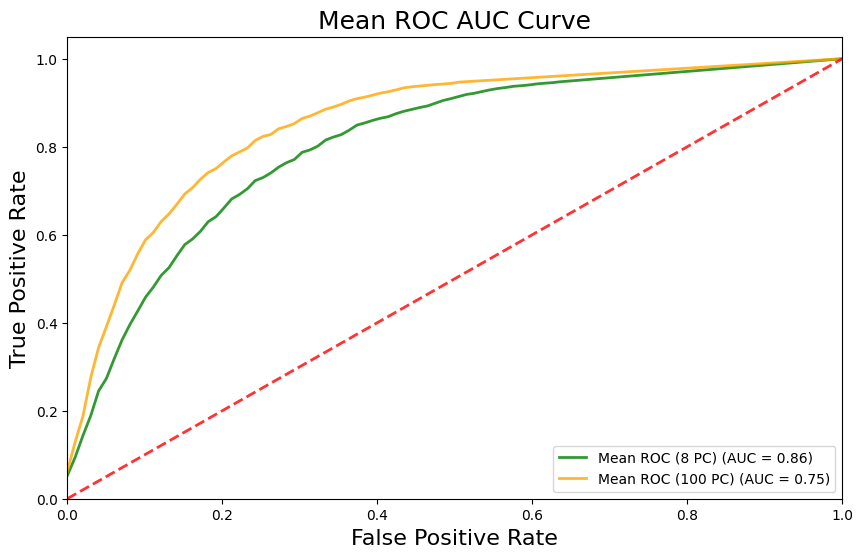

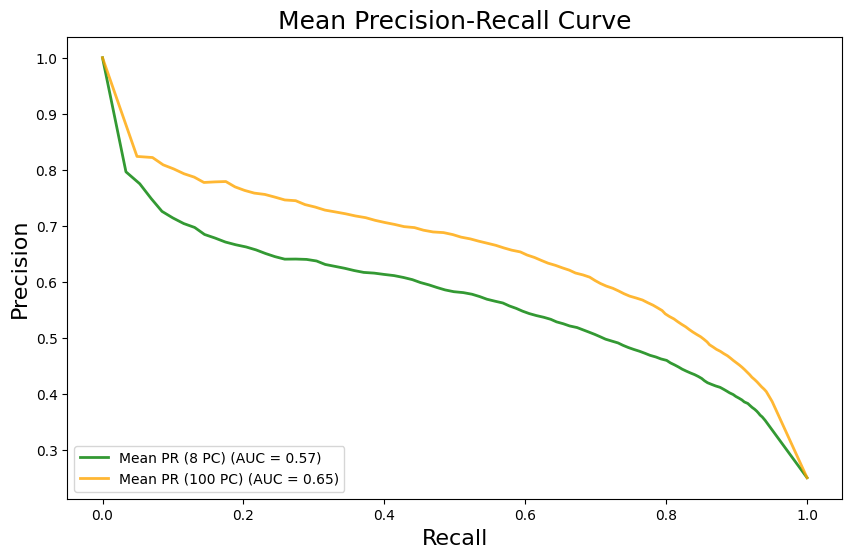

Final Training Set Class Distribution:
flare_class_encoded
200    142
300    142
100    128
400     23
Name: count, dtype: int64


In [ ]:
#MULTICLASS - 100 PC

# Load your dataset
df = pd.read_csv("100 PC.csv")

# Ensure class distributions
print("Original Class Distribution:")
print(df['flare_class_encoded'].value_counts())

def create_multiclass_splits(n_repeats=10):
    all_splits = []

    for repeat in range(n_repeats):
        try:
            # Randomly select unique samples for each class
            b_class_samples = resample(df[df['flare_class_encoded'].between(100, 199)],
                                       replace=False, n_samples=128, random_state=repeat)
            c_class_samples = resample(df[df['flare_class_encoded'].between(200, 299)],
                                       replace=False, n_samples=142, random_state=repeat)
            m_class_samples = resample(df[df['flare_class_encoded'].between(300, 399)],
                                       replace=False, n_samples=142, random_state=repeat)
            x_class_samples = resample(df[df['flare_class_encoded'].between(400, 499)],
                                       replace=False, n_samples=23, random_state=repeat)

            # Combine selected samples to form a complete dataset
            complete_data = pd.concat([b_class_samples, c_class_samples, m_class_samples, x_class_samples])
            X = complete_data.drop(columns=['flare_class_encoded'])
            y = complete_data['flare_class_encoded']  # Target value

            all_splits.append((X, y))
        except ValueError as e:
            print(f"Repeat {repeat}: Error - {e}")
            continue

    return all_splits

def evaluate_model_with_knn(X, y, n_splits=10):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Define the parameter grid
    param_grid = {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }

    model_knn = KNeighborsClassifier()
    grid_search = GridSearchCV(estimator=model_knn, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

    accuracy_scores = []
    roc_auc_scores = []
    pr_auc_scores = []
    best_params_list = []
    fpr_list = []
    tpr_list = []
    precision_list = []
    recall_list = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        grid_search.fit(X_train, y_train)
        best_model_knn = grid_search.best_estimator_
        best_params_list.append(grid_search.best_params_)

        y_pred = best_model_knn.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)

        y_test_bin = label_binarize(y_test, classes=np.unique(y_train))
        test_pred_prob = best_model_knn.predict_proba(X_test)
        roc_auc = roc_auc_score(y_test_bin, test_pred_prob, multi_class='ovr')
        roc_auc_scores.append(roc_auc)

        precision, recall, _ = precision_recall_curve(y_test_bin.ravel(), test_pred_prob.ravel())
        pr_auc = average_precision_score(y_test_bin, test_pred_prob)
        pr_auc_scores.append(pr_auc)

        fpr, tpr, _ = roc_curve(y_test_bin.ravel(), test_pred_prob.ravel())
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        precision_list.append((precision, len(precision)))
        recall_list.append((recall, len(recall)))

    return np.mean(accuracy_scores), np.mean(roc_auc_scores), np.mean(pr_auc_scores), best_params_list, accuracy_scores, roc_auc_scores, pr_auc_scores, fpr_list, tpr_list, precision_list, recall_list

# Evaluate multi-class classification with 10-fold cross-validation
multiclass_splits = create_multiclass_splits()
if len(multiclass_splits) == 0:
    print("No valid splits created.")
else:
    mean_acc_list = []
    mean_roc_auc_list = []
    mean_pr_auc_list = []
    best_params_list = []
    all_accuracy_scores = []
    all_roc_auc_scores = []
    all_pr_auc_scores = []
    all_fpr = []
    all_tpr = []
    all_precision = []
    all_recall = []

    for X, y in multiclass_splits:
        (mean_acc, mean_roc_auc, mean_pr_auc, best_params, accuracy_scores, roc_auc_scores, pr_auc_scores, fpr_list, tpr_list, precision_list, recall_list) = evaluate_model_with_knn(X, y)
        mean_acc_list.append(mean_acc)
        mean_roc_auc_list.append(mean_roc_auc)
        mean_pr_auc_list.append(mean_pr_auc)
        best_params_list.extend(best_params)
        all_accuracy_scores.extend(accuracy_scores)
        all_roc_auc_scores.extend(roc_auc_scores)
        all_pr_auc_scores.extend(pr_auc_scores)
        all_fpr.extend(fpr_list)
        all_tpr.extend(tpr_list)
        all_precision.extend(precision_list)
        all_recall.extend(recall_list)

    overall_mean_accuracy_100PC = np.mean(mean_acc_list)
    overall_mean_roc_auc_100PC = np.mean(mean_roc_auc_list)
    overall_mean_pr_auc_100PC = np.mean(mean_pr_auc_list)

    print(f"Overall Mean Accuracy: {overall_mean_accuracy_100PC}")
    print(f"Overall Mean ROC AUC: {overall_mean_roc_auc_100PC}")
    print(f"Overall Mean PR AUC: {overall_mean_pr_auc_100PC}")


  # combined Plot Mean ROC AUC Curve (8;100 PC)
    mean_fpr_100PC = np.linspace(0, 1, 100)
    mean_tpr_100PC = np.mean([np.interp(mean_fpr_100PC, fpr, tpr) for fpr, tpr in zip(all_fpr, all_tpr)], axis=0)
    mean_tpr_100PC[-1] = 1.0
    mean_roc_auc_100PC = auc(mean_fpr_100PC, mean_tpr_100PC)

    plt.figure(figsize=(10, 6))
    plt.plot(mean_fpr_8PC, mean_tpr_8PC, color='green', label=f'Mean ROC (8 PC) (AUC = {mean_roc_auc_8PC:.2f})', lw=2, alpha=.8)
    plt.plot(mean_fpr_100PC, mean_tpr_100PC, color='orange', label=f'Mean ROC (100 PC) (AUC = {mean_roc_auc_100PC:.2f})', lw=2, alpha=.8)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate',fontsize=16)
    plt.ylabel('True Positive Rate',fontsize=16)
    plt.title('Mean ROC AUC Curve',fontsize=18)
    plt.legend(loc="lower right")
    plt.savefig("ROC AUC curve - KNN MULTICLASS 8;100 PC.png")
    plt.show()

    # Interpolate precision-recall to a common set of recall points for mean calculation
    mean_precision_100PC = np.zeros_like(mean_fpr_100PC)
    for precision, length in all_precision:
        mean_precision_100PC += np.interp(mean_fpr_100PC, np.linspace(0, 1, length), precision)
    mean_precision_100PC /= len(all_precision)

    mean_recall_100PC = np.mean([np.interp(mean_fpr_100PC, np.linspace(0, 1, length), recall) for recall, length in all_recall], axis=0)

     # combined Plot Mean Precison-Recall Curve (8;100 PC)
    plt.figure(figsize=(10, 6))
    plt.plot(mean_recall_8PC, mean_precision_8PC, color='green', label=f'Mean PR (8 PC) (AUC = {overall_mean_pr_auc_8PC:.2f})', lw=2, alpha=.8)
    plt.plot(mean_recall_100PC, mean_precision_100PC, color='orange', label=f'Mean PR (100 PC) (AUC = {overall_mean_pr_auc_100PC:.2f})', lw=2, alpha=.8)
    plt.xlabel('Recall',fontsize=16)
    plt.ylabel('Precision',fontsize=16)
    plt.title('Mean Precision-Recall Curve',fontsize=18)
    plt.legend(loc="lower left")
    plt.savefig("PR curve - KNN MULTICLASS 8;100 PC.png")
    plt.show()

# Print final class distributions for debugging
if len(multiclass_splits) > 0:
    X, y = multiclass_splits[0]
    print(f"Final Training Set Class Distribution:\n{y.value_counts()}")

